In [1]:
import os
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F
import torch.nn as nn
import matplotlib.cm as cm
import pandas as pd

from torch.autograd import Variable

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import Image

In [2]:
file = open("hw4_tr7.pkl",'rb')
train_data = pickle.load(file)
file.close()

In [3]:
file = open("hw4_te7.pkl",'rb')
test_data = pickle.load(file)
file.close()

In [4]:
train_data.shape


(6265, 28, 28)

In [5]:
BATCH = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH)

In [6]:
# Ref: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
class Flat_Tensor(nn.Module):
    def forward(self, data):
        return data.view(data.size(0), -1)

class UnFlat_Tensor(nn.Module):
    def forward(self, data):
        return data.view(data.size(0), 64, 1, 1)

In [7]:
# References:
    # https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py
#     https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
    
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            Flat_Tensor()
        )
        
        self.fc1 = nn.Linear(64, 5)
        self.fc2 = nn.Linear(64, 5)
        self.fc3 = nn.Linear(5, 64)
        
        self.decoder = nn.Sequential(
            UnFlat_Tensor(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size())
        z = mu.cuda() + std.cuda() * esp.cuda()
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        x = x[:,np.newaxis, :,:].cuda()
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):        
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [8]:
model = NeuralNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# Ref: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb
def loss_fn(recon_x, x, mu, logvar):
    recon_x = recon_x.reshape((recon_x.shape[0],28,28))
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [10]:
epochs = 600

In [11]:
total_loss_list = []
recontruction_loss = []
kl_loss = []
for epoch in range(epochs):
    for idx, images in enumerate(train_loader):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images.cuda(), images.cuda(), mu.cuda(), logvar.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # For debugging purpose
    total_loss_list.append(loss.data.cpu().numpy())
    recontruction_loss.append(bce.data.cpu().numpy())
    kl_loss.append(kld.data.cpu().numpy())

 

C:\Users\gurjaspal\Anaconda3\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


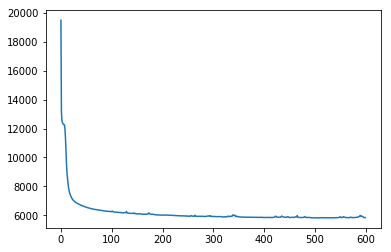

In [12]:
plt.plot(range(epochs), total_loss_list)
plt.show()

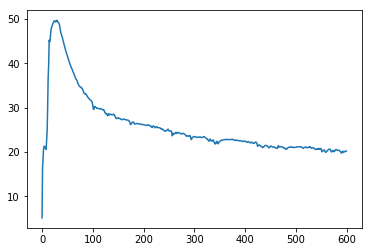

In [13]:
plt.plot(range(epochs), kl_loss)
plt.show()

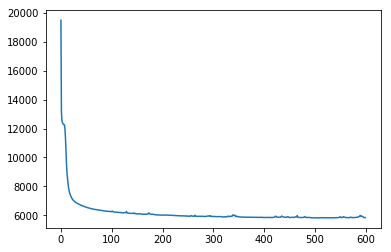

In [14]:
plt.plot(range(epochs), recontruction_loss)
plt.show()

In [15]:
state_dict = model.state_dict()

In [16]:
def show_batch(batch):
    grid = torchvision.utils.make_grid(batch, nrow=5)
    plt.figure(figsize=(10,20))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))
    plt.axis('off')
    

In [17]:
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data = data.cuda()
        recon_batch, mu, logvar = model(data)

torch.Size([28, 1, 28, 28])


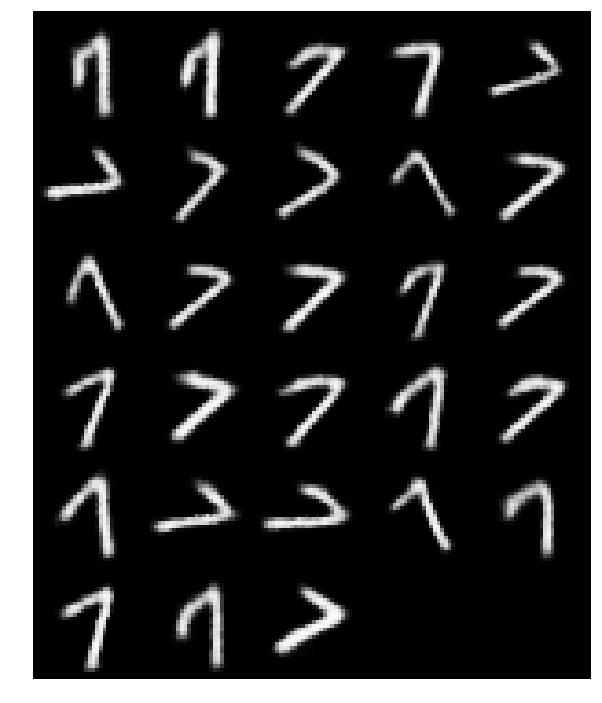

In [18]:
# displaying the reconstructed batch from test set
print(recon_batch.shape)
show_batch(recon_batch)

torch.Size([28, 28, 28])


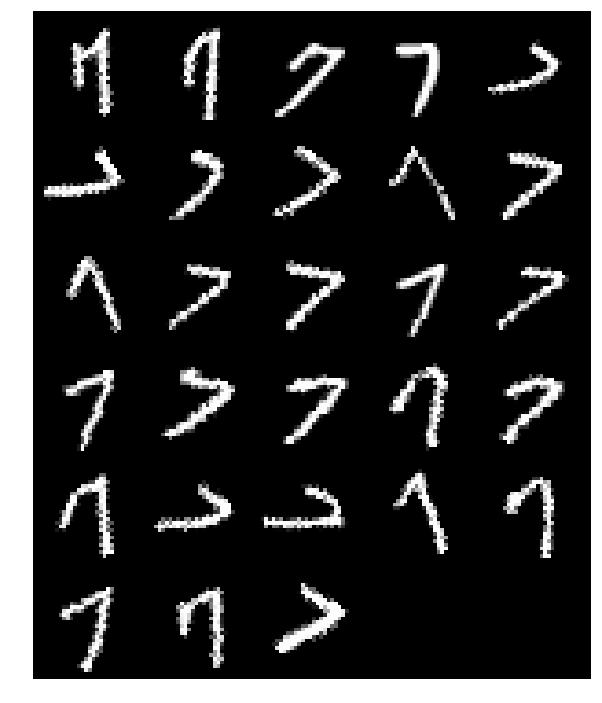

In [19]:
# displaying the original images
print(data.shape)
show_batch(data[:,np.newaxis,:,:])

In [20]:
state_dict = model.state_dict()
original_latent_vector =  state_dict['fc2.weight']

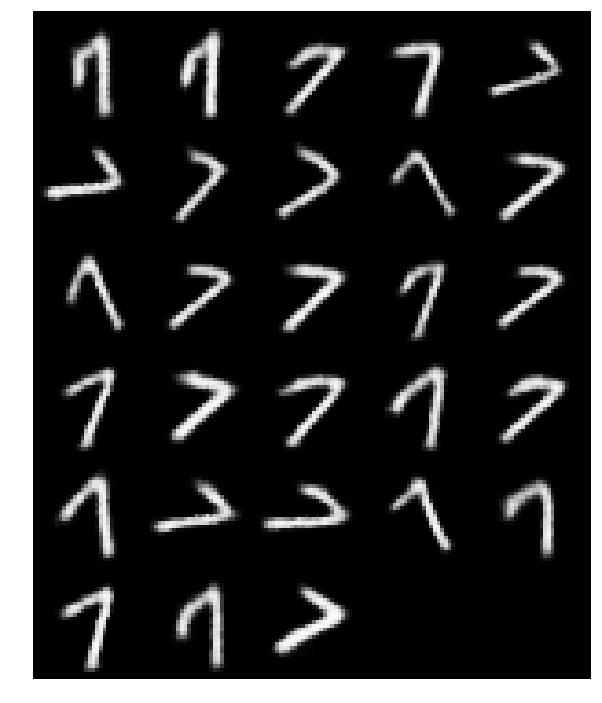

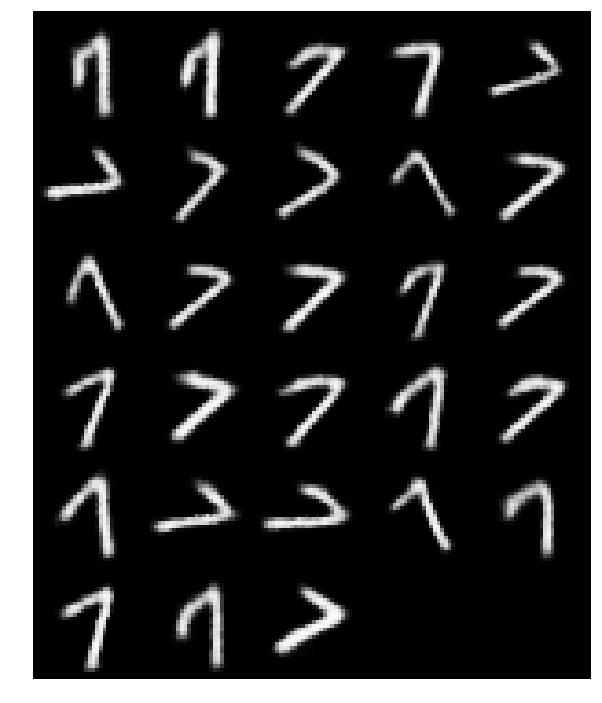

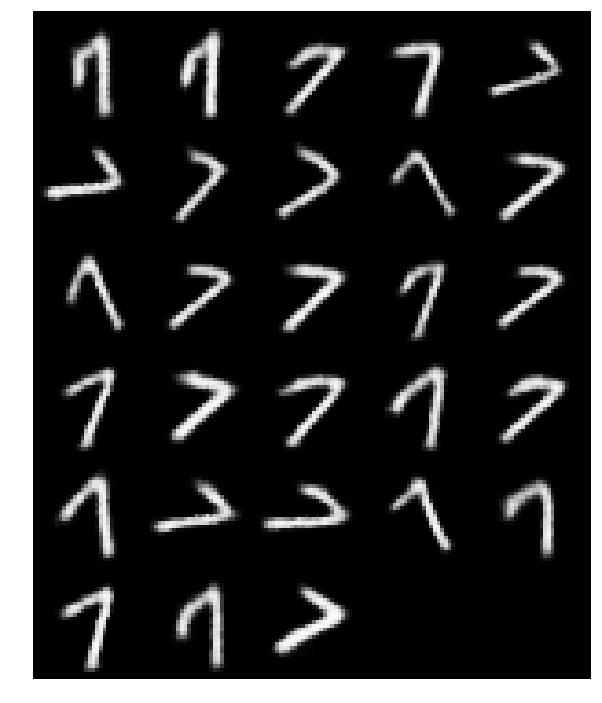

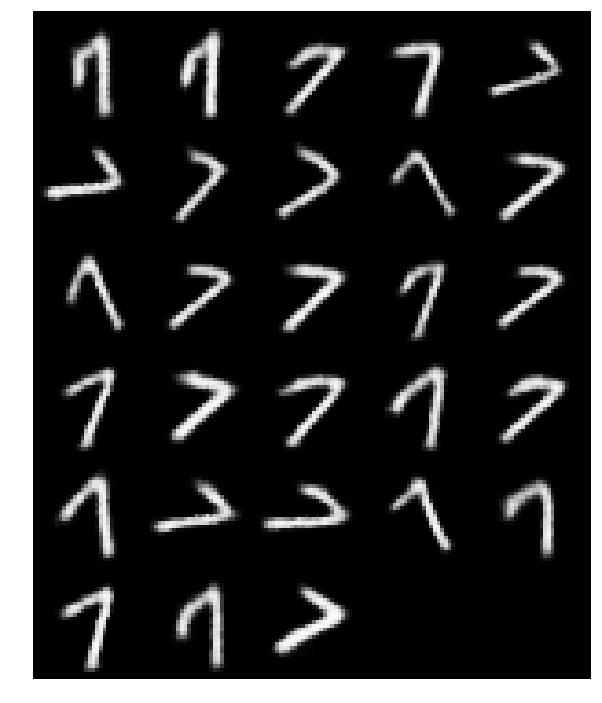

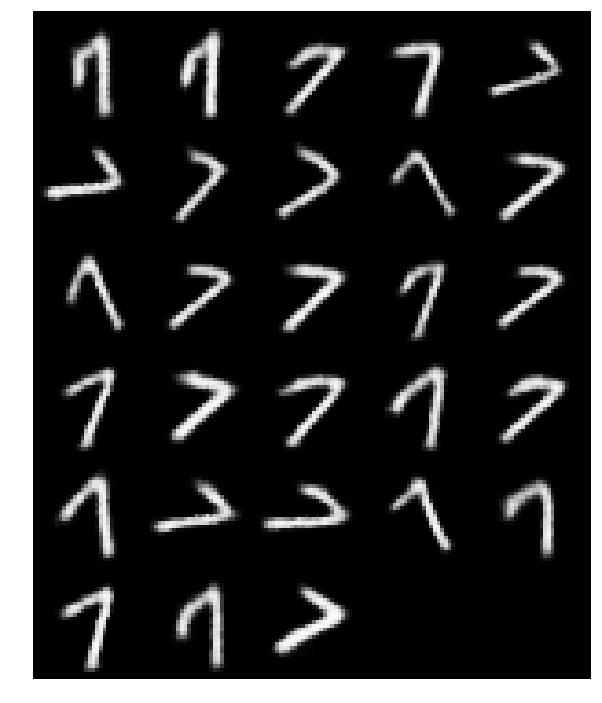

In [21]:

# print(latent_vector.shape)
for i in range(5):
    v = original_latent_vector.clone()
    v[i,:] = torch.randn(64)
    state_dict['fc2.weight'] = v
    model.load_state_dict(state_dict)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            data = data.cuda()
            reconstruction, mu, logvar = model(data)
    show_batch(recon_batch)